# Basic Example

This notebook follows the structure discussed in [https://luci-fitting.readthedocs.io/en/latest/example_basic.html](https://luci-fitting.readthedocs.io/en/latest/example_basic.html).

We will go through the steps necessary to use `LUCI`. As you will see, there are only a handful of commands required to use `LUCI`. This example is intentionally loquacious since it is, after all, an example :) 

In order to use `LUCI`, we need to import her, have data available to use, and have an initial guess. We have provided a command below to download a sample data cube that can be used to run the examples in this notebook.

#### * If you have not yet downloaded the sample data cube, uncomment the below cell and run and download the sample data cube.  
This will save a 900MB file called `sample_data.hdf5` to the **`ExampleData`** directory in the **`LUCI`** folder. Do not be concerned if it takes a few minutes to download.

In [1]:
# !wget -O Data/NGC628_SN3.hdf5  https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/CFHT/2307000z.hdf5?RUNID=xc9le6u8llecp7fp

Let's start with importing `LUCI`. Just as described on the *readthedocs* page, we need to point our system path to our install location of the **`LUCI`** folder. 

We assume that the main project directory is the parent of the current Notebooks directory. For example, **`LUCI`**'s main directory lives in `/home/jessie/repos/LUCI` and my current directory is `/home/jessie/repos/LUCI/Examples`

However, we also provde instructions for how to point to the proper path if your main project directory is in a different directory. In this example, the data directory is `/home/carterrhea/Docments/NGC628`.

In [1]:
# Imports
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

# Get location of LUCI 
path = os.path.abspath(os.path.pardir)  
sys.path.insert(0, path)  # add LUCI to the available paths

from LuciBase import Luci
import LUCI.LuciPlotting as lplt

%config Completer.use_jedi=False  # enable autocompletion when typing in Jupyter notebooks

2023-01-30 11:36:54.763547: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2023-01-30 11:36:54.763579: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Set the required parameters. We will be using our machine learning algorithm to get the initial guesses - this happens under the hood in `LuciFit`, so that the user is not required to think about the initial guess

In [2]:
# Initialize paths and set parameters
Luci_path = path + '/'
cube_dir = path + '/Data/ExampleData/'  # Path to data cube
cube_dir = '/mnt/carterrhea/carterrhea/NGC628'  # Full path to data cube (example 2)
cube_name = 'NGC628_SN3.merged.cm1.1.0'  # don't add .hdf5 extension
object_name = 'NGC628'
filter_name = 'SN3'
redshift = 0.000133  # Redshift of object
resolution = 1000 # The actual resolution is 400, but we don't have ML algorithms for that resolution, so use 1000

Intialize our LUCI object

In [3]:
cube = Luci(Luci_path, cube_dir + '/' + cube_name, cube_dir, object_name, redshift, resolution)

Reading in data...


100%|██████████| 9/9 [01:15<00:00,  8.38s/it]


2023-01-30 11:38:14.033971: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2023-01-30 11:38:14.034013: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-30 11:38:14.034047: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2023-01-30 11:38:14.034324: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Create a deep frame

In [4]:
cube.create_deep_image()

Existing deep frame extracted from hdf5 file.


Let's extract a background region and take a look at it. The background region is defined in a ds9 region file in the `ExampleData` folder.

100%|██████████| 2064/2064 [00:01<00:00, 1184.38it/s]


<AxesSubplot:xlabel='Wavelength [cm-1]', ylabel='Flux [ergs s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$]'>

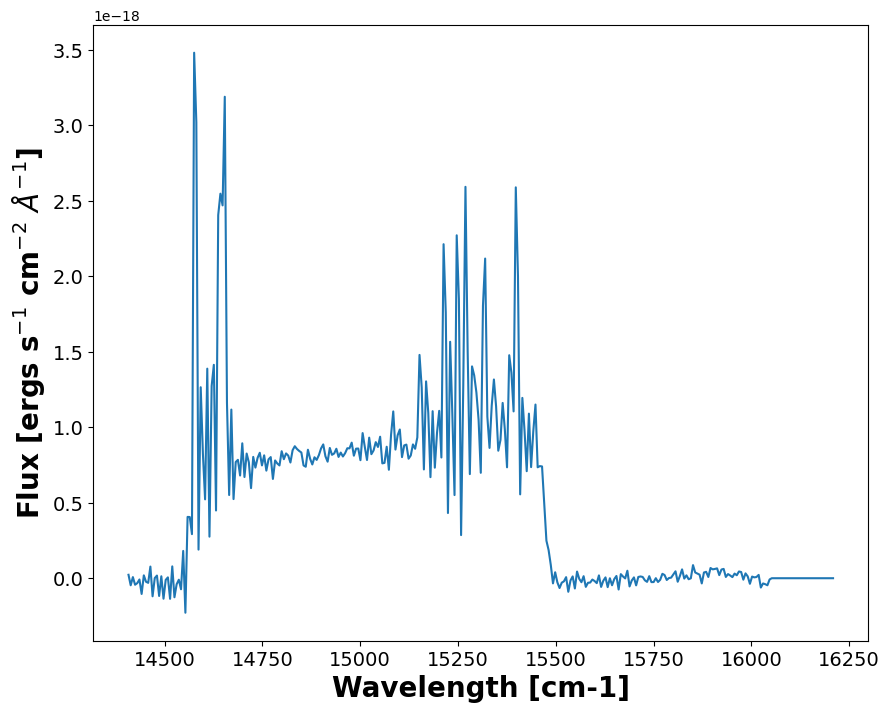

In [5]:
# We use 'mean = True' to take the mean of the emission in the region instead of the sum
bkg_axis, bkg_sky = cube.extract_spectrum_region(cube_dir+'/bkg.reg', mean=True)
lplt.plot_spectrum(bkg_axis, bkg_sky)

We now fit part of our cube defined by the bounding box `500 < x < 1100` and `700 < y < 1300` with a Gaussian on the Halpha line, the NII-doublet, and the SII-doublet with a binning of 2. We will also tie all of our parameters together. 

For this example, we do not calculate the errors because it slows down calculations, but note that it can easily be done by adding the argument `uncertainty_bool=True`. If you want the full Bayesian calculation you can add `bayes_bool=True`.

In [8]:
# Fit!
vel_map, broad_map, flux_map, chi2_fits = cube.fit_cube(
    ['Halpha', 'NII6548', 'NII6583', 'SII6716', 'SII6731'],  # lines
    'sincgauss',   # fit function
    [1,1,1,1,1],  # velocity relationship 
    [1,1,1,1,1],  # sigma relationship
    1050, 1200,    # x bounds
    900, 1100,    # y bounds
    bkg=bkg_sky, binning=1,  
    n_threads=6
)

2023-01-30 11:42:56.454079: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://f2187ad0-50e3-4f53-986a-b46aaef7f722/assets
INFO:tensorflow:Assets written to: ram://e9da4e72-5bc4-454a-b272-48bd9b989965/assets
INFO:tensorflow:Assets written to: ram://6bf24fa4-b1b7-4e5f-b572-5db456e46f79/assets
INFO:tensorflow:Assets written to: ram://edad1017-a3d3-43a8-9740-da55f47de0bb/assets
INFO:tensorflow:Assets written to: ram://c008f01d-ff21-4778-8096-5ca0ee786aa2/assets
INFO:tensorflow:Assets written to: ram://a8cd77d7-7879-48e5-804c-674a3b3f2f5f/assets
INFO:tensorflow:Assets written to: ram://df35db95-8395-49b9-a5ad-37b8527777e3/assets
INFO:tensorflow:Assets written to: ram://87a31606-45e8-4de9-b3a0-ff5d8e0c8cd7/assets
INFO:tensorflow:Assets written to: ram://f885226d-46f7-4bd1-bf9f-ca873610acf3/assets
INFO:tensorflow:Assets written to: ram://c08803bf-8482-499b-8e7b-07f6053d6b6e/assets
INFO:tensorflow:Assets written to: ram://8226eca8-4d44-4eee-8a9d-f8121fcf4d20/assets
INFO:tensorflow:Assets written to: ram://02515eb8-1e48-4f91-8bb9-

INFO:tensorflow:Assets written to: ram://b9c14992-aeeb-4dee-b104-e8473601ad7a/assets
INFO:tensorflow:Assets written to: ram://ab5632b6-0e5a-4ce0-a3df-ec4d06e6573c/assets
INFO:tensorflow:Assets written to: ram://2920f454-e098-4530-ab76-d3156314ba86/assets
INFO:tensorflow:Assets written to: ram://c0eafd8f-1fa9-4aa7-bfa2-574de94def2f/assets
INFO:tensorflow:Assets written to: ram://0ed30c8d-6d7c-4284-b802-73e017d82d96/assets
INFO:tensorflow:Assets written to: ram://41c087f7-989c-4085-afca-8868ae93159c/assets


INFO:tensorflow:Assets written to: ram://6207ac71-c607-4b18-a4a5-2c5c46c38c7f/assets
INFO:tensorflow:Assets written to: ram://4708b8fc-3bbc-4ba3-abc0-a92d0112548e/assets
INFO:tensorflow:Assets written to: ram://f09c9227-37b0-4863-bf1c-d1c43f2315de/assets
INFO:tensorflow:Assets written to: ram://af3d052b-ff53-4ec4-aa66-d8e49fb972b8/assets
INFO:tensorflow:Assets written to: ram://d3885107-d42d-4e93-974a-70da058e0167/assets
INFO:tensorflow:Assets written to: ram://88481d52-5557-44e1-9e03-d43cff09a253/assets


INFO:tensorflow:Assets written to: ram://fc1fbf81-b08b-45b6-98f6-d5b2e47866d8/assets
INFO:tensorflow:Assets written to: ram://b1296098-3675-4740-85dc-202518362791/assets
INFO:tensorflow:Assets written to: ram://34590f87-209d-4883-ae6d-8d8d80305b0e/assets
INFO:tensorflow:Assets written to: ram://43c0c696-7ad2-4e0c-a24a-c8265d5f56ec/assets
INFO:tensorflow:Assets written to: ram://0c3ab555-9eef-48db-9c3a-dfdb28d5c118/assets
INFO:tensorflow:Assets written to: ram://598d9113-91b6-4c7d-9372-13d7867222f4/assets


INFO:tensorflow:Assets written to: ram://24795dce-17b7-4c37-8b79-60b2487cee35/assets
INFO:tensorflow:Assets written to: ram://7703095d-5561-4ec3-a27a-b9f9127d5ea7/assets
INFO:tensorflow:Assets written to: ram://4000845c-6ffa-4c1e-bd0b-30774dc30ecb/assets
INFO:tensorflow:Assets written to: ram://f9be1561-f38e-4c9a-a982-eb82002b9fca/assets
INFO:tensorflow:Assets written to: ram://e4aa0c86-c3ce-44f9-85f6-f6e1033bba3c/assets
INFO:tensorflow:Assets written to: ram://e5151622-ae14-42b4-8970-a3468f0c54d8/assets


INFO:tensorflow:Assets written to: ram://f4d63aae-6f86-4156-b14b-aed646cd822f/assets
INFO:tensorflow:Assets written to: ram://9ca21e3c-524a-4e7b-9a78-a5b6fd3faac7/assets
INFO:tensorflow:Assets written to: ram://c6137aa7-3e2a-43b9-a665-5e5a2c1b1685/assets
INFO:tensorflow:Assets written to: ram://0a031037-abe8-4325-8105-59dab36a2d81/assets
INFO:tensorflow:Assets written to: ram://4e4d14f9-d0c0-4638-94e0-6b56b16192fd/assets
INFO:tensorflow:Assets written to: ram://58f3d908-ff74-48b8-9a5d-43dc7c88144e/assets


INFO:tensorflow:Assets written to: ram://cad34281-3240-460b-8f65-e58890f3061b/assets
INFO:tensorflow:Assets written to: ram://f4762604-adff-4480-9c89-a45911e9755b/assets
INFO:tensorflow:Assets written to: ram://4b855825-8157-4011-bc65-420bbe7fbaf5/assets
INFO:tensorflow:Assets written to: ram://0820603b-762e-4ab4-b9ac-19a242b25dcb/assets
INFO:tensorflow:Assets written to: ram://2bd8d6cd-7306-40d0-b189-86b571230a7d/assets
INFO:tensorflow:Assets written to: ram://465e239c-5d67-4c45-94f1-85853d161b12/assets


INFO:tensorflow:Assets written to: ram://1f2dae9a-ada3-4588-b6d6-0d254d357f87/assets
INFO:tensorflow:Assets written to: ram://f73bdd62-4f5e-40d4-a129-7caae8f9ae51/assets
INFO:tensorflow:Assets written to: ram://a97e0e7b-fe95-4fa8-a638-52ce0a56c29b/assets
INFO:tensorflow:Assets written to: ram://847f7bb2-56df-4069-8037-4211eb62173d/assets
INFO:tensorflow:Assets written to: ram://3c6101dc-e934-4fe9-a82e-5e74e4e45276/assets
INFO:tensorflow:Assets written to: ram://3160c7f2-1e81-4198-a889-70b0317f398d/assets


INFO:tensorflow:Assets written to: ram://75965f67-992b-43bc-8ee1-aaf7c27dc455/assets
INFO:tensorflow:Assets written to: ram://24906408-8055-42cb-b8c3-dff4677b1d47/assets
INFO:tensorflow:Assets written to: ram://2b7604bf-476b-4b77-b085-77839e004bc1/assets
INFO:tensorflow:Assets written to: ram://cf048dba-7094-47fc-ae76-352ccdf54d8f/assets
INFO:tensorflow:Assets written to: ram://d6c42f75-5411-438b-a50e-6908f075f06c/assets
INFO:tensorflow:Assets written to: ram://4a5d4bed-2db7-4d7c-9069-20a3028025d2/assets


INFO:tensorflow:Assets written to: ram://018229ca-8354-4dc1-85cc-8c7e72165b69/assets
INFO:tensorflow:Assets written to: ram://bfd8d097-56c5-4c38-9d8a-de753dba1a29/assets
INFO:tensorflow:Assets written to: ram://bcd11880-a35d-4c58-8a2e-c9466b226cf4/assets
INFO:tensorflow:Assets written to: ram://cbf351a1-49f0-470e-9a14-d3e5fab3ac8b/assets
INFO:tensorflow:Assets written to: ram://ca1a0d65-066e-43e3-bb7d-eda8d1f3620e/assets
INFO:tensorflow:Assets written to: ram://4379a3a1-6b22-4a98-aaca-2f3433a1704d/assets


INFO:tensorflow:Assets written to: ram://39e6fa29-8f10-48d0-bb98-d586c21ef073/assets
INFO:tensorflow:Assets written to: ram://8bae5741-b4e8-4318-8423-8ff43dfb2066/assets
INFO:tensorflow:Assets written to: ram://1607a8f3-1b50-455c-ab83-bc299b74e7be/assets
INFO:tensorflow:Assets written to: ram://282e7e3b-63da-4138-a0e6-bfd737905e85/assets
INFO:tensorflow:Assets written to: ram://a664483f-0e7c-4296-9ab2-f44a8e9b5f5f/assets
INFO:tensorflow:Assets written to: ram://ba45bc58-a83b-46b1-82ae-cd750c3a48ca/assets


INFO:tensorflow:Assets written to: ram://c50ac49a-326f-43e0-9168-795e3ae436ea/assets
INFO:tensorflow:Assets written to: ram://2ae28478-f309-47a9-b6ac-dab6b6bd9216/assets
INFO:tensorflow:Assets written to: ram://b02b7c61-f865-4315-92bf-41ad2ab2af8a/assets
INFO:tensorflow:Assets written to: ram://2ad8c43b-bca5-4740-83ab-e4a31c643b85/assets
INFO:tensorflow:Assets written to: ram://fbd2ea90-05fb-44c9-a384-0800831c3d0e/assets
INFO:tensorflow:Assets written to: ram://6a4e5923-7d9b-4afe-a1f0-a14b8197bce0/assets


INFO:tensorflow:Assets written to: ram://7d68ceab-52aa-4737-b8d0-05c64fab9809/assets
INFO:tensorflow:Assets written to: ram://78b9ba82-6593-452f-a183-a2692e105592/assets
INFO:tensorflow:Assets written to: ram://4138c8d4-3e80-4e82-8c3a-65157defaef1/assets
INFO:tensorflow:Assets written to: ram://9babc80b-6c4a-4909-bfb0-3b19f21e0c83/assets
INFO:tensorflow:Assets written to: ram://34b5e860-ca49-45c8-a646-1120fcb54a29/assets
INFO:tensorflow:Assets written to: ram://dc14d66c-fa4d-40bf-9372-18f5a1a3bb9d/assets


INFO:tensorflow:Assets written to: ram://bf61155c-ab23-4fd5-a7a7-cecf7457ac44/assets
INFO:tensorflow:Assets written to: ram://633d194b-2dd9-4887-8fe0-6ae6718b14d9/assets
INFO:tensorflow:Assets written to: ram://b75e9311-3dc5-48f2-9cba-613e60917c88/assets
INFO:tensorflow:Assets written to: ram://2f89944f-6d38-4dd2-b2e8-05a251c69a11/assets
INFO:tensorflow:Assets written to: ram://d26dad6c-1942-4a09-a1ec-426eb36de860/assets
INFO:tensorflow:Assets written to: ram://8a81decb-a1d1-428e-a39c-33da208a03ce/assets


INFO:tensorflow:Assets written to: ram://46177f92-4f15-43e0-881e-c85b3e88b2ad/assets
INFO:tensorflow:Assets written to: ram://cf01fbda-ef9c-44de-b27e-1424360b8116/assets
INFO:tensorflow:Assets written to: ram://50db5518-faa6-414c-baba-e03b6d64bd03/assets
INFO:tensorflow:Assets written to: ram://f0187ae2-1a81-4fee-9101-73b2e4a1606e/assets
INFO:tensorflow:Assets written to: ram://20092c21-0463-4bd6-b37e-99e72ea5010c/assets
INFO:tensorflow:Assets written to: ram://617dfd55-e045-4d56-8bc4-101bd1a0d720/assets


INFO:tensorflow:Assets written to: ram://b8a6df58-1ec0-4e1e-9c7b-cbfcc24df39a/assets
INFO:tensorflow:Assets written to: ram://d7d5a5d6-3b2e-46dc-8919-91706e90884c/assets
INFO:tensorflow:Assets written to: ram://45ff95ef-91a2-4931-b2b3-35ac798a9ee4/assets
INFO:tensorflow:Assets written to: ram://90f9e287-0a63-43b1-b880-aec5335bc042/assets
INFO:tensorflow:Assets written to: ram://fe583492-752c-4701-883b-84b80fc4f903/assets
INFO:tensorflow:Assets written to: ram://06c5c705-8038-407b-b4df-d74809953fc6/assets


INFO:tensorflow:Assets written to: ram://d92fc178-d28e-45a9-ba4c-203a86c65586/assets
INFO:tensorflow:Assets written to: ram://6c62cc4d-a89d-48c7-94a7-e050d8bf5afe/assets
INFO:tensorflow:Assets written to: ram://feb6fede-1786-49d0-9b33-babb4857e640/assets
INFO:tensorflow:Assets written to: ram://5bc75658-fd40-4ba0-8691-95f2feb62bc3/assets
INFO:tensorflow:Assets written to: ram://3d0c2672-7ed0-4985-ba00-b46402704911/assets
INFO:tensorflow:Assets written to: ram://916aaad8-f389-48f7-b9ac-c90cd41fea9c/assets


INFO:tensorflow:Assets written to: ram://857cf858-9cea-4452-a304-35c1cef379f7/assets
INFO:tensorflow:Assets written to: ram://452f960d-8563-4ab5-8649-6060f8c8a049/assets
INFO:tensorflow:Assets written to: ram://ba54df6c-d872-43db-8ec0-1a294af7c734/assets
INFO:tensorflow:Assets written to: ram://d5ce2177-9112-4934-a194-66fbfc486be9/assets
INFO:tensorflow:Assets written to: ram://cd7f9a07-93ca-4d05-acc1-92def3c20adb/assets
INFO:tensorflow:Assets written to: ram://aaa2616c-2a9e-4d28-b285-56158cc1409c/assets


INFO:tensorflow:Assets written to: ram://e8086629-b155-4faa-bb51-6c85ef574caf/assets
INFO:tensorflow:Assets written to: ram://ab2fffa7-cddb-4dda-9773-be1a366ab1a5/assets
INFO:tensorflow:Assets written to: ram://16eb8343-80e3-4388-9bfb-60a366ae9802/assets
INFO:tensorflow:Assets written to: ram://000d31b5-efdb-4ab5-b4d9-1f5e287907c6/assets
INFO:tensorflow:Assets written to: ram://5530ded0-7bdb-4eea-bd1e-4555e0fdd1ce/assets
INFO:tensorflow:Assets written to: ram://32cae74f-1dda-4d8e-a090-5e903b30e130/assets


INFO:tensorflow:Assets written to: ram://bebb5201-2bc1-449b-87ac-afc16b514879/assets
INFO:tensorflow:Assets written to: ram://ebe92d45-0ab1-4128-8e72-7d4a8fb0539e/assets
INFO:tensorflow:Assets written to: ram://86c8b5b5-b240-473a-a68a-c4df627c24d0/assets
INFO:tensorflow:Assets written to: ram://2a83bc10-b8c2-4719-b697-a1a578233f09/assets
INFO:tensorflow:Assets written to: ram://3439443c-1b3b-4be8-88f7-e0e496e3dbd6/assets
INFO:tensorflow:Assets written to: ram://e0798202-aa68-45b1-86b6-e3e9160350fa/assets


INFO:tensorflow:Assets written to: ram://99c94e69-7a70-449b-a924-59bc3786f85d/assets
INFO:tensorflow:Assets written to: ram://bd212e54-b5ab-471a-ba02-89bb5bf091e3/assets
INFO:tensorflow:Assets written to: ram://5b5202b8-5ffc-47bd-90e9-3b6229207332/assets
INFO:tensorflow:Assets written to: ram://9338a437-41e1-4a13-a287-2ca387703803/assets
INFO:tensorflow:Assets written to: ram://30160ee9-3f6c-4aea-9418-cfb76afd6683/assets
INFO:tensorflow:Assets written to: ram://076a8c1a-5303-4a4b-83c3-1078009d6b36/assets


INFO:tensorflow:Assets written to: ram://76395e8d-083f-411e-aed4-6641f9085d8a/assets
INFO:tensorflow:Assets written to: ram://5b3ad31b-fda8-4b00-ae08-c377d071fb90/assets
INFO:tensorflow:Assets written to: ram://5d8c0914-4207-4937-80d3-9e85f55c665e/assets
INFO:tensorflow:Assets written to: ram://513fdcde-337a-4c71-a091-2c87705a15e1/assets
INFO:tensorflow:Assets written to: ram://a68baa39-7b47-4f66-a223-42485ba08524/assets
INFO:tensorflow:Assets written to: ram://72160ee9-c318-42f6-afc5-fe21f49d92a6/assets


INFO:tensorflow:Assets written to: ram://1767a2bb-e4c9-498e-972d-1501f09e6920/assets
INFO:tensorflow:Assets written to: ram://a5821104-84ec-4f29-8e09-c5829a7c8c5b/assets
INFO:tensorflow:Assets written to: ram://60bda0b4-c2c5-4b1e-89f9-21a2529c96d7/assets
INFO:tensorflow:Assets written to: ram://cfd3284c-3603-47af-b651-4311b88bc86b/assets
INFO:tensorflow:Assets written to: ram://81465d86-0104-4fc6-ab73-6793491aee32/assets
INFO:tensorflow:Assets written to: ram://9a289815-5c43-435e-8630-4abb179410ad/assets


INFO:tensorflow:Assets written to: ram://0c945dcb-a04e-45d6-b8c3-86721714dee8/assets
INFO:tensorflow:Assets written to: ram://59775d95-a551-43f2-a984-f9c2c0ac2b44/assets
INFO:tensorflow:Assets written to: ram://056cc7b6-cf04-4746-bbc9-3cd9857bb468/assets
INFO:tensorflow:Assets written to: ram://ce110c6d-e7c6-4bf3-8e9b-aa3b52642bfb/assets
INFO:tensorflow:Assets written to: ram://d5718fc3-8ce9-4f8a-9c19-2a8bbca195a4/assets
INFO:tensorflow:Assets written to: ram://25aab3e7-ac36-4f73-af1a-261144e04203/assets


INFO:tensorflow:Assets written to: ram://b21e1df1-435d-42bf-8751-3768ee26fdd2/assets
INFO:tensorflow:Assets written to: ram://d4329a16-1a03-4436-ae32-5d53e7f9cac5/assets
INFO:tensorflow:Assets written to: ram://14c8e702-1eae-4e74-aa3c-7417089289bf/assets
INFO:tensorflow:Assets written to: ram://1d854757-8097-492d-9d00-2db00c13f9ab/assets
INFO:tensorflow:Assets written to: ram://4d9d4a2d-0cd9-4c70-a583-4c9c23388986/assets
INFO:tensorflow:Assets written to: ram://cd5a3b96-0416-453c-85bb-f8cb5d708d96/assets


INFO:tensorflow:Assets written to: ram://f7038d90-00ac-4733-b3c4-55ee23eae98c/assets
INFO:tensorflow:Assets written to: ram://2947f5d4-a63a-46a8-ab19-26de64dabbc5/assets
INFO:tensorflow:Assets written to: ram://f5890cf8-d1a8-4818-b373-94159f18fe97/assets
INFO:tensorflow:Assets written to: ram://f2a709fa-b415-4556-a81b-55d3add01310/assets
INFO:tensorflow:Assets written to: ram://96890254-1f8f-4b9e-9d8e-2e2dde549b0c/assets
INFO:tensorflow:Assets written to: ram://b70a7ad8-fbac-4141-be86-6a9f28b21b4d/assets


INFO:tensorflow:Assets written to: ram://7d5a0c11-f213-4be4-b674-d9228b22d49f/assets
INFO:tensorflow:Assets written to: ram://a2b6b1de-4a24-4e16-b3e8-e2a8c2cd0fe6/assets
INFO:tensorflow:Assets written to: ram://697e05d0-5315-49d1-86ee-86f9c88b7566/assets
INFO:tensorflow:Assets written to: ram://8554b67a-f40e-4317-998d-eafaa73d808d/assets
INFO:tensorflow:Assets written to: ram://deb38524-a3b6-403e-b209-f8e4f3e84c75/assets
INFO:tensorflow:Assets written to: ram://9b499f23-b53e-4afc-ae64-31429f87dffb/assets


INFO:tensorflow:Assets written to: ram://b4512ba4-aaba-40cd-a551-4abf981a5519/assets
INFO:tensorflow:Assets written to: ram://668635e0-eb61-49aa-9d02-158038e2a7aa/assets
INFO:tensorflow:Assets written to: ram://392fde17-77f1-427a-a86a-491e21e69c4e/assets
INFO:tensorflow:Assets written to: ram://92a52349-b358-4dbb-94c8-2ca05e7ca6f2/assets
INFO:tensorflow:Assets written to: ram://149b4242-5ade-402f-9d44-f44ac3d1612e/assets
INFO:tensorflow:Assets written to: ram://71c41b00-38ad-4116-a4d6-345b7eb9bf68/assets


INFO:tensorflow:Assets written to: ram://80d202f2-56e6-4a96-be43-8fbf80c6613d/assets
INFO:tensorflow:Assets written to: ram://99ec9322-980f-491d-9f80-fea9d44ce80e/assets
INFO:tensorflow:Assets written to: ram://242bc5e3-9afa-4bdb-87a8-e460be492491/assets
INFO:tensorflow:Assets written to: ram://4681ddc2-237f-464e-aa83-540f1baf7f9f/assets
INFO:tensorflow:Assets written to: ram://764f3060-a3ce-4da3-b1b6-0e01912e2e53/assets


INFO:tensorflow:Assets written to: ram://7e54e9dc-dbba-4e95-b6c2-84d13f54d3ee/assets
INFO:tensorflow:Assets written to: ram://818d6012-de11-4770-a4f3-1c467d623575/assets
INFO:tensorflow:Assets written to: ram://543276a1-396d-4019-8f5f-9aae681eaf1d/assets
INFO:tensorflow:Assets written to: ram://ebe50934-ce0f-4ca4-a345-74167f0fd465/assets
INFO:tensorflow:Assets written to: ram://eb88da6b-3e92-4c2b-84e5-88fd6b908bd6/assets
INFO:tensorflow:Assets written to: ram://449f7af7-9f61-4981-94e1-34c5dff14546/assets


INFO:tensorflow:Assets written to: ram://cad2d1b7-b279-4a98-b5d1-0e962bbeb77e/assets
INFO:tensorflow:Assets written to: ram://a0d3092b-3067-4b56-ae49-93a78a455def/assets
INFO:tensorflow:Assets written to: ram://a9d52171-5bec-4494-9975-4e24ce149892/assets
INFO:tensorflow:Assets written to: ram://e1504d00-819e-489a-86d4-1bd60d273c6c/assets
INFO:tensorflow:Assets written to: ram://cb671736-d0e0-44b3-bfb7-35d2630d8251/assets
INFO:tensorflow:Assets written to: ram://f8d9653d-bac1-4609-9108-bb0018aae2ec/assets
INFO:tensorflow:Assets written to: ram://e9f6debb-c4cf-43c5-b3d7-76b07925a76d/assets


INFO:tensorflow:Assets written to: ram://93548e7c-d1c2-4de8-9be4-ed4f39ad7088/assets
INFO:tensorflow:Assets written to: ram://a07f681f-bb5d-48df-aefb-3394e389f9ca/assets
INFO:tensorflow:Assets written to: ram://0f24b5a5-b2e7-4fb1-9b54-062c7341637d/assets
INFO:tensorflow:Assets written to: ram://1401c577-acae-456b-9984-ca257936fd33/assets
INFO:tensorflow:Assets written to: ram://97d10728-2bfd-48f6-b74f-677786874c14/assets
INFO:tensorflow:Assets written to: ram://c4bbccb4-8c48-4404-ad6c-358ab89ad14e/assets


100%|██████████| 200/200 [40:54<00:00, 12.27s/it]


INFO:tensorflow:Assets written to: ram://c16d712e-441c-4c1f-8710-3469d7fe9321/assets
INFO:tensorflow:Assets written to: ram://b45f94ff-f3bf-4669-ac76-9a8c544491c8/assets


Let's take a look at the flux map for Halpha. 

** Note that if the user enters 'flux' then the plotting method automatically takes the log base 10 and plots that. The flux is generally easier to visualize in log space.

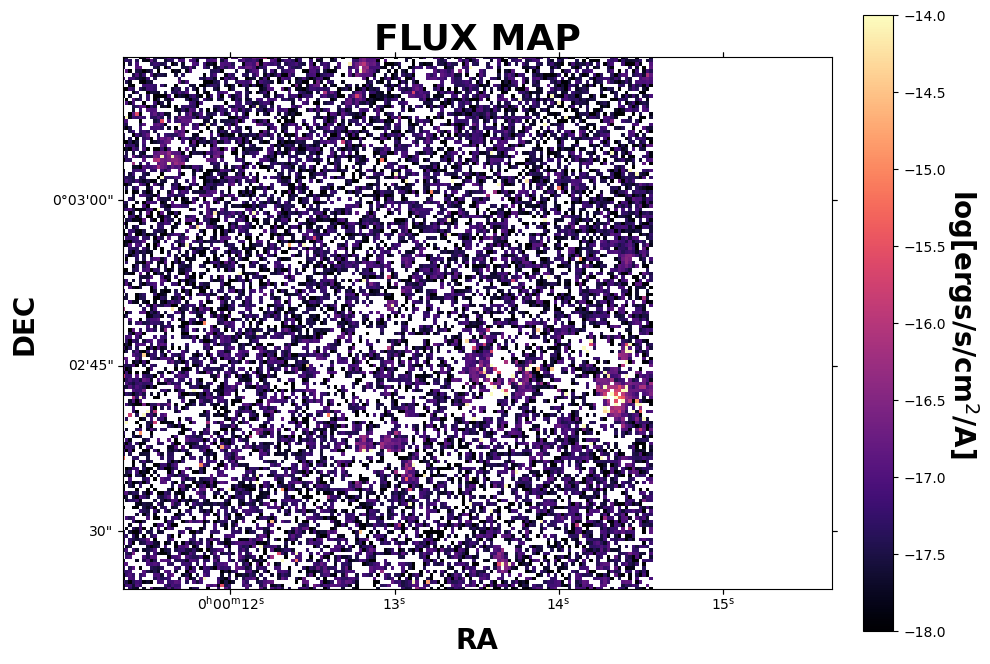

In [9]:
lplt.plot_map(flux_map[:,:,0], 'flux', object_name, filter_name, cube_dir, cube.header, clims=[-18, -14])

Let's also take a look at the velocity and broadening maps.

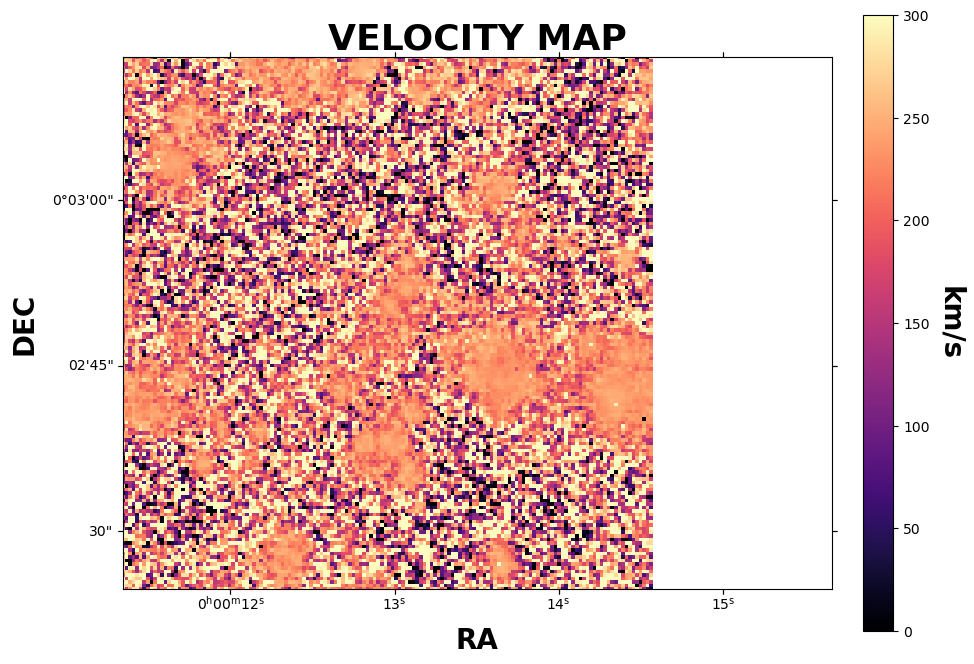

In [10]:
lplt.plot_map(vel_map[:,:,0], 'velocity', object_name, filter_name, cube_dir, cube.header, clims=[0, 300])

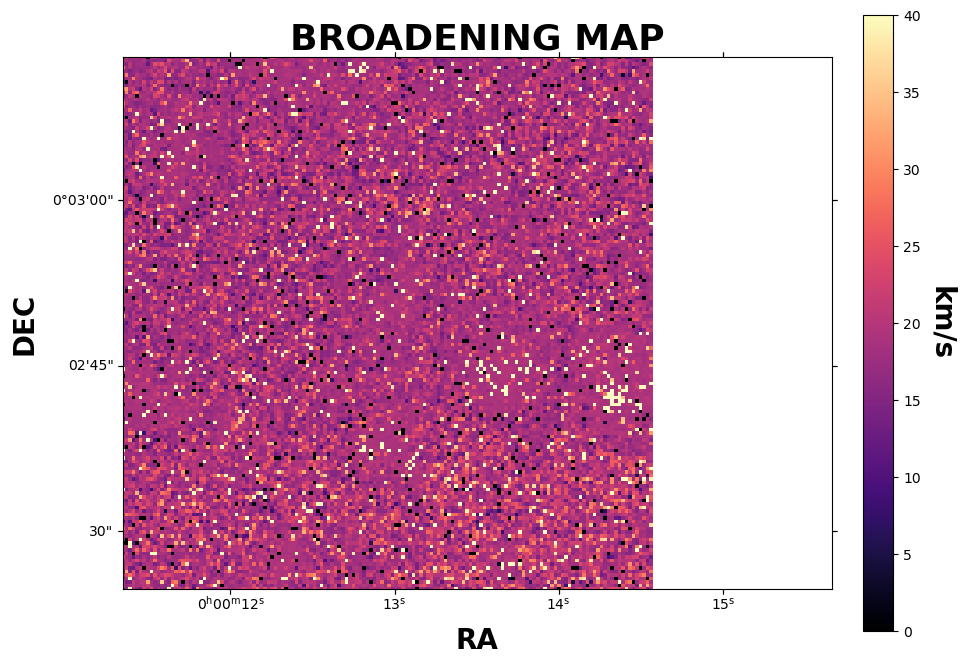

In [12]:
lplt.plot_map(broad_map[:,:,0], 'broadening', object_name, filter_name, cube_dir, cube.header, clims=[0, 40])

And that is it! Congratulations, you have just used `LUCI`! 